In [6]:
from netCDF4 import Dataset
import cartopy.crs as ccrs
import matplotlib.animation as animation
from IPython import display
import cartopy
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import pickle
from cmaps import grain_type_colormap, get_grain_tick_labels

my_cmap = grain_type_colormap()

In [9]:
d = Dataset('../notebooks/2020_09.nc')
print(d['time'])
d

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (720,)
filling on, default _FillValue of -2147483647 used



/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2021-08-17 12:14:44 GMT by grib_to_netcdf-2.20.0: /opt/ecmwf/mars-client/bin/grib_to_netcdf -S param -o /cache/data3/adaptor.mars.internal-1629202476.504791-5613-14-b492ef61-90b3-4624-b5b9-97b8447061e5.nc /cache/tmp/b492ef61-90b3-4624-b5b9-97b8447061e5-adaptor.mars.internal-1629202438.6395233-5613-4-tmp.grib
    dimensions(sizes): longitude(1440), latitude(121), time(720)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 ptype(time,latitude,longitude), int16 tp(time,latitude,longitude)
    groups: 

In [3]:
lon = d['longitude']
lat = d['latitude']

In [4]:
type_data_raw = np.array(d['ptype'])
prec_data_raw = np.array(d['tp'])*1000

In [17]:
%matplotlib widget

type_data = type_data_raw.copy()
prec_data = prec_data_raw.copy()

fig = plt.figure()    

ax = plt.axes(projection=ccrs.NorthPolarStereo())


ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())

bg = ax.pcolormesh(np.array(lon), np.array(lat), np.full(type_data[0].shape, np.nan),
                   vmin = 0, vmax = 9,
             transform=ccrs.PlateCarree(),zorder=0,cmap=my_cmap)

anno = ax.annotate('',xycoords='axes fraction',xy=(0.99,0.93),ha='right',fontsize='x-large')

ax.scatter(101.184955,89.005759,transform=ccrs.PlateCarree(),s=100,color='r',marker='x')

type_data[prec_data<(5/24)] = 0

cbar = fig.colorbar(bg,ax=ax,ticks=np.arange(-0.5,8.51,1))

cbar.ax.set_yticklabels(['']+get_grain_tick_labels())

def animate(frame):

    bg.set_array(np.rint(type_data[frame])[:-1,:-1].ravel())
    
    doy = frame/24
    
    date = datetime.date(2020,9,1) + datetime.timedelta(days=doy+1)
    
    anno.set_text(f'{date}')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
type_data[prec_data<(5/24)] = 0

start_doy = (datetime.datetime(2020,9,10)-datetime.datetime(2020,9,1)).days
end_doy = (datetime.datetime(2020,9,17)-datetime.datetime(2020,9,1)).days

ani = animation.FuncAnimation(fig,
                              animate,
                             frames= range((start_doy-1)*24,(end_doy-1)*24,1),
                             )    

video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

# Find nearest reanalysis pixel to PS on 14th

In [5]:
datetimes = [datetime.datetime(2020,1,1)+datetime.timedelta(hours=x) for x in range(8784)]

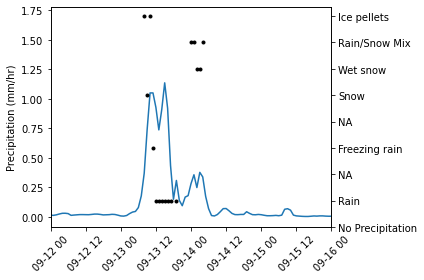

In [49]:
lon_ps, lat_ps = np.argmin(abs(np.array(lon)-101.185)), np.argmin(abs(np.array(lat)-89.00))

###

type_series = type_data_raw[:,lat_ps,lon_ps]
prec_series = prec_data_raw[:,lat_ps,lon_ps]

type_series[prec_series<(5/24)] = 0

###

fig, ax = plt.subplots(1,1)
ax.plot(datetimes,prec_series)
ax.set_ylabel('Precipitation (mm/hr)')
ax.set_xlim(datetime.datetime(2020,9,12),datetime.datetime(2020,9,16))
ax.tick_params('x',rotation=45)

ax2 = ax.twinx()

type_series = type_series.copy()

type_series[type_series==0] = np.nan

ax2.scatter(datetimes,type_series,color='k',marker='.')

ax2.set_yticks(np.arange(0,9))
ax2.set_yticklabels(get_grain_tick_labels())

plt.tight_layout()

plt.savefig('ROS_sept_2020.jpg',dpi=500,bbox_inches='tight')

plt.show()

In [94]:
start=list(datetimes).index(datetime.datetime(2020,9,12))
end=list(datetimes).index(datetime.datetime(2020,9,16))
v1 = prec_series[start:end]

In [98]:
(330-174)/174 

0.896551724137931

12.218579480069373


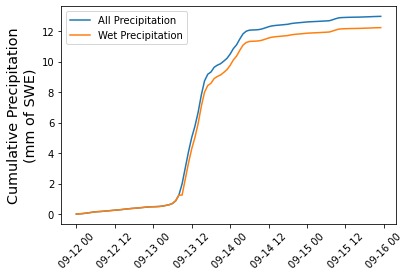

In [99]:
v2 = v1.copy()

v2[type_series[start:end] == 5] = 0
v2[type_series[start:end] == 8] = 0

plt.plot(datetimes[start:end],np.cumsum(v1),label='All Precipitation')
plt.plot(datetimes[start:end],np.cumsum(v2),label='Wet Precipitation')

print(np.cumsum(v2)[-1])

plt.ylabel('Cumulative Precipitation\n(mm of SWE)', fontsize='x-large')

plt.xticks(rotation=45)

plt.legend()

plt.show()

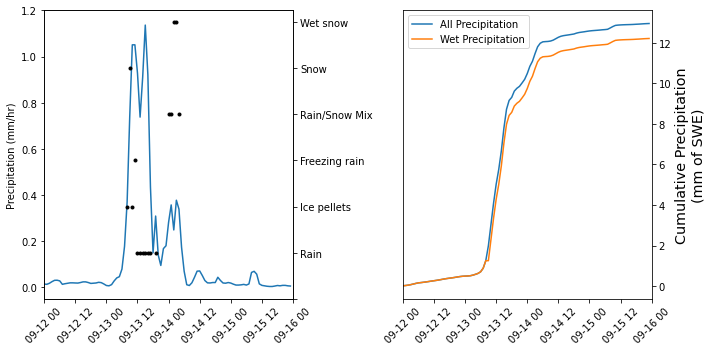

In [116]:
lon_ps, lat_ps = np.argmin(abs(np.array(lon)-101.185)), np.argmin(abs(np.array(lat)-89.00))

###

type_series = np.around(type_data_raw[:,lat_ps,lon_ps].copy())
prec_series = prec_data_raw[:,lat_ps,lon_ps].copy()

type_series[prec_series<(1/24)] = 0

###

fig, (ax, axr) = plt.subplots(1,2,figsize=(10,5))

ax.plot(datetimes[start:end],prec_series[start:end])
ax.set_ylabel('Precipitation (mm/hr)')
ax.set_xlim(datetime.datetime(2020,9,12),datetime.datetime(2020,9,16))
ax.set_ylim(-0.05,1.2)
ax.tick_params('x',rotation=45)

ax2 = ax.twinx()

type_series[type_series==0] = np.nan

type_series[type_series==8]=2

type_series[type_series==7]=4

ax2.scatter(datetimes[start:end],type_series[start:end],color='k',marker='.')

ax2.set_yticks(np.arange(0,7))
ax2.set_yticklabels(get_grain_tick_labels2())


axr.plot(datetimes[start:end],np.cumsum(v1),label='All Precipitation')
axr.plot(datetimes[start:end],np.cumsum(v2),label='Wet Precipitation')

axr.set_ylabel('Cumulative Precipitation\n(mm of SWE)', fontsize='x-large')
axr.set_xlim(datetime.datetime(2020,9,12),datetime.datetime(2020,9,16))
axr.tick_params('x',rotation=45)
axr.yaxis.tick_right()
axr.yaxis.set_label_position("right")

axr.legend()

plt.tight_layout()

plt.savefig('ROS_sept_2020.jpg',dpi=500,bbox_inches='tight')

plt.show()

obj = (start, end, datetimes, v1, v2, type_series, prec_series)

pickle.dump(obj, open('../pickles/event.p', 'wb'))

In [109]:
np.cumsum(v2)[-1]

12.218579480069373

In [106]:
np.cumsum(v2)[-1]/np.cumsum(v1)[-1]

7 * 3.30 - 7 * 1.74



10.919999999999998

In [90]:
# 12.95 mm of fresh water is 12.95 * 1023/1000 mm of sea water

sw_swe = 11.5 *(1023/1000)

sw_swe * 1023/882

13.6452193877551